# Grove Temperature Sensor 1.2

This example shows how to use the [Grove Temperature Sensor v1.2](http://www.seeedstudio.com/wiki/Grove_-_Temperature_Sensor_V1.2). You will also see how to plot a graph using matplotlib. The Grove Temperature sensor produces an analog signal, and requires an ADC. 

The Grove Light Sensor, Pmod Stickit, and Grove I2C ADC are used for this example. 

You can read a single value of temperature or read multiple values at regular intervals for a desired duration.

Additionally, at the end of this notebook, we highlight a Python only solution with single-sample read functionality.

<tr>
<td> <img src=http://www.xilinx.com/content/dam/xilinx/imgs/prime/ZYBO_revB-top-1000x755%20(1).jpg alt="Drawing" style="width: 250px;"/> </td>
<td> <img src=http://www.xess.com/static/media/product/product_cover_1.jpg alt="Drawing" style="width: 250px;"/> </td>
<td> <img src=http://www.seeedstudio.com/wiki/images/b/b0/Temperature1.jpg alt="Drawing" style="width: 250px;"/> </td>
</tr>

### 1. Load overlay.

In [1]:
from pynq.pl import Overlay
Overlay("pmod.bit").download()

### 2. Read single temperature
This example shows on how to get a single temperature sample from the Grove TMP sensor.

The Grove ADC is assumed to be attached to the GR4 connector of the StickIt. The StickIt module is assumed to be plugged in the 1st PMOD labeled JB. The Grove TMP sensor is connected to the other connector of the Grove ADC.

Grove ADC provides a raw sample which is converted into resistance first and then converted into temperature.

In [2]:
import math
from pynq.pmods import Grove_TMP

# Grove Stickit is connected to PMOD 1 labeled JB
# Grove ADC is connected to GR 4. 
tmp = Grove_TMP(1, 4)
temperature = tmp.read()
print(float("{0:.2f}".format(temperature)),'degree Celsius')

26.74 degree Celsius


### 3. Start logging once every 100ms for 10 seconds
Executing the next cell will start logging the temperature sensor values every 100ms, and will run for 10s. You can try touch/hold the temperature sensor to vary the measured temperature.

You can vary the logging interval and the duration by changing the values 100 and 10 in the cellbelow. The raw samples are stored in the internal memory, and converted into temperature values.

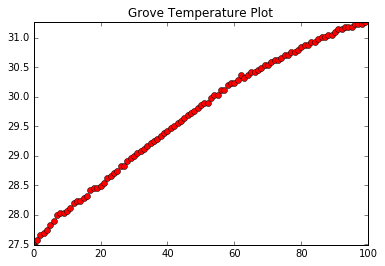

In [3]:
import time

%matplotlib inline
import matplotlib.pyplot as plt

tmp.set_log_interval_ms(100)
tmp.start_log()
time.sleep(10) # Change input during this time
tmp_log = tmp.get_log()

plt.plot(range(len(tmp_log)), tmp_log, 'ro')
plt.title('Grove Temperature Plot')
min_tmp_log = min(tmp_log)
max_tmp_log = max(tmp_log)
plt.axis([0, len(tmp_log), min_tmp_log, max_tmp_log])
plt.show()

### 4. A Pure Python class to exercise the AXI IIC Controller inheriting from PMOD_IIC
This class is ported from http://www.seeedstudio.com/wiki/Grove_-_Temperature_Sensor.

In [4]:
# Python Class for Grove Temperature Sensor

from time import sleep
from math import log
from pynq.pmods import pmod_const
from pynq.pmods.pmod_iic import PMOD_IIC

class Python_Grove_TMP(PMOD_IIC):
    """This class controls the grove temperature sensor.
    
    This class inherits from the PMODIIC class.
    
    Note
    ----
    The index of the PMOD pins:
    upper row, from left to right: {vdd,gnd,3,2,1,0}.
    lower row, from left to right: {vdd,gnd,7,6,5,4}.
    
    Attributes
    ----------
    iop : _IOP
        The _IOP object returned from the DevMode.
    scl_pin : int
        The SCL pin number.
    sda_pin : int
        The SDA pin number.
    iic_addr : int
        The IIC device address.
    
    """
    def __init__(self, pmod_id, gr_id, model = 'v1.2'): 
        """Return a new instance of a grove OLED object. 
    
        Note
        ----
        The pmod_id 0 is reserved for XADC (JA).
        
        StickIt groups are numbered as:
        gr_id    => SCL, SDA => PMOD pins 
        1        =>  D0, D1   =>  0, 4
        2        =>  D2, D3   =>  1, 5
        3        =>  D7, D6   =>  7, 3
        4        =>  D5, D4   =>  6, 2
        
        Parameters
        ----------
        pmod_id : int
            The PMOD ID (1, 2, 3, 4) corresponding to (JB, JC, JD, JE).
        gr_id: int
            The group ID on StickIt, from 1 to 4.
        model : string
            Temperature sensor model (can be found on the device).
            
        """
        if (gr_id not in [3,4]):
            raise ValueError("Valid StickIt group IDs are 3 and 4.")
        [scl_pin,sda_pin] = pmod_const.STICKIT_PINS_GR[gr_id]

        
        # Each of the sensor revisions use different thermistors
        # Each with their own B value constant
        if model == 'v1.2':
            self.bValue = 4250  # v1.2 uses thermistor NCP18WF104F03RC
        elif model == 'v1.1':
            self.bValue = 4250  # v1.1 uses thermistor NCP18WF104F03RC
        else:
            self.bValue = 3975  # v1.0 uses thermistor TTC3A103*39H
        
        super().__init__(pmod_id, scl_pin, sda_pin, 0x50)
        
        # Initialize the Grove ADC         
        self.send([0x2,0x20]);   
        
    def read(self):
        """Read temperature in Celsius from grove temperature sensor.
        
        Parameters
        ----------
        None
        
        Returns
        -------
        float
            Temperature reading in Celsius.
        
        """
        val = self._read_grove_adc()
        R = 4095.0/val - 1.0
        temp = 1.0/(log(R)/self.bValue + 1/298.15)-273.15
        return temp
        
    def _read_grove_adc(self):       
       self.send([0])
       bytes = self.receive(2)
       return 2*(((bytes[0] & 0x0f) << 8) | bytes[1])


In [5]:
from pynq import PL

# Flush IOP#1 state
PL.reset_ip_dict()

py_tmp = Python_Grove_TMP(1,4)
temperature = py_tmp.read()
print(float("{0:.2f}".format(temperature)),'degree Celsius')

30.88 degree Celsius
